In [1]:
import xarray as xr
import xroms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''


FS: 10th jan 2024

- Returning to my work, I have to adapt and check the consistency of this script to use with the diagnostic file
- Also test in a few rows and so I can calculate by hand the values
- I have than to play with the variables and do the same calculations I did using Neils scripts as reference
* When all of this it is sorted out, organize the script to run using all the files on Katana
* Ask Colette to run the model with diagnostic output. 










'''

'\n\n\nFS: 10th jan 2024\n\n- Returning to my work, I have to adapt and check the consistency of this script to use with the diagnostic file\n- Also test in a few rows and so I can calculate by hand the values\n- I have than to play with the variables and do the same calculations I did using Neils scripts as reference\n* When all of this it is sorted out, organize the script to run using all the files on Katana\n* Ask Colette to run the model with diagnostic output. \n\n\n\n\n\n\n\n\n\n\n'

In [3]:
# I can't read the diagnostic file with xroms due to the lacking of some variables it needs to calculate other variables.
# Thus, I am using the average file to get grid metrics information to be used during heat budget calculation
ds_metric = xroms.open_netcdf('/mnt/c/Users/z5392640/OneDrive - UNSW/Documents/PhD/scientific_topics/heat_budget/neil_nci/colette/outer_avg.nc')
ds = xr.open_dataset('/mnt/c/Users/z5392640/OneDrive - UNSW/Documents/PhD/scientific_topics/heat_budget/neil_nci/colette/outer_dia.nc')
# ds, dg

In [4]:
# # # Selecting a small area
# xi_slice = slice(60, 160)
# eta_slice = slice(0, 50)

# # New area
# xi_slice = slice(40, 140)
# eta_slice = slice(0, -50)

# This is how we get the whole domain
xi_slice = slice(None, None)
eta_slice = slice(None, None)

lat_rho = ds["lat_rho"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
lon_rho = ds["lon_rho"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
lat_u = ds["lat_u"].isel(eta_u=eta_slice, xi_u=xi_slice)
lon_u = ds["lon_u"].isel(eta_u=eta_slice, xi_u=xi_slice)
lat_v = ds["lat_v"].isel(eta_v=eta_slice, xi_v=xi_slice)
lon_v = ds["lon_v"].isel(eta_v=eta_slice, xi_v=xi_slice)
pm = ds["pm"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
pn = ds["pn"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
h = ds["h"].isel(eta_rho=eta_slice, xi_rho=xi_slice)

area=np.divide(1,pm*pn)

In [5]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                    eta_psi: 316, xi_psi: 271, ocean_time: 30)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 1994-02-01 ... 1994-03-02
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/139)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    salt_hdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_xdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_ydiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_sdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_vdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_rate      (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
Attributes: (12/34)
    file:              outer_dia.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS diagnostics file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [6]:
ds.lon_u

<xarray.DataArray 'lon_u' (eta_u: 317, xi_u: 271)>
[85907 values with dtype=float64]
Coordinates:
    lon_u    (eta_u, xi_u) float64 ...
    lat_u    (eta_u, xi_u) float64 ...
Dimensions without coordinates: eta_u, xi_u
Attributes:
    long_name:      longitude of U-points
    units:          degree_east
    standard_name:  longitude
    field:          lon_u, scalar

In [7]:
# Getting the values where we have nan to use as mask
land_mask = np.isnan(ds.temp_hadv.isel(ocean_time=0, s_rho=-1, eta_rho=eta_slice, xi_rho=xi_slice))

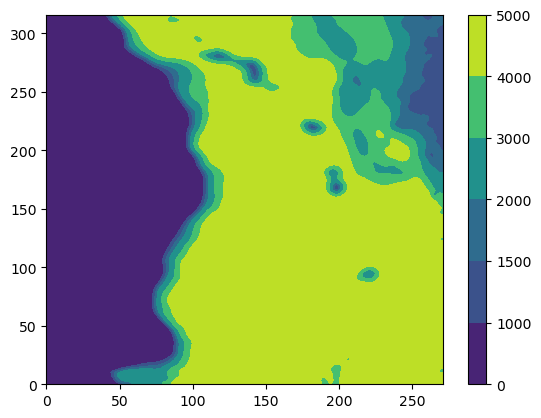

In [8]:
# Using the mask
# dg.temp.isel(ocean_time=0, s_rho=-1).where(~land_mask).where(h <= 200).isel(eta_rho=slice(30, -50), xi_rho=slice(30, -170)).plot(y='lat_rho', x='lon_rho')
h = h.where(~land_mask)
plt.contourf(h, levels=[0, 1000, 1500, 2000, 3000, 4000, 5000])
plt.colorbar()

In [9]:
# Fill in land with zeros:
h = h.fillna(0)
# h.where(h<=200).plot()


/tmp/ipykernel_310/2530893891.py:17: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in sc.collections:


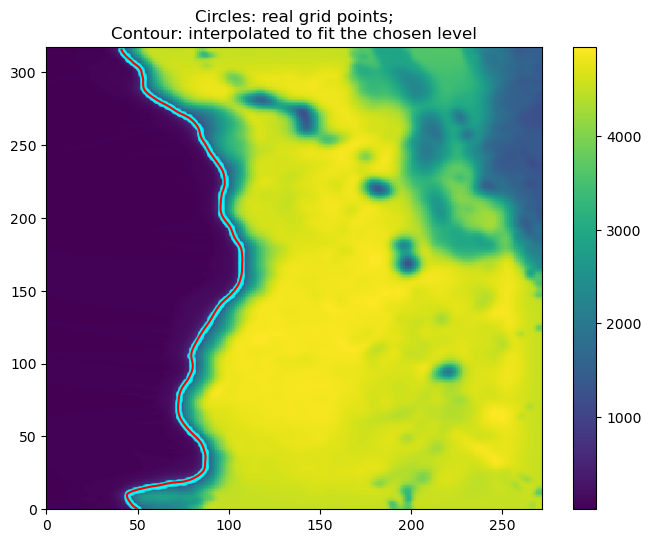

In [10]:
# Contours and grid does not perfectly match because the contour can be anything, and so, it is interpolated.
contour_depth = 1000.

x_var = lon_rho
y_var = lat_rho

fig = plt.figure(figsize = (8, 6))
# count = 165 # contour 87 for 2000m isobath, 165 for 1500m
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth], colors='red')
plt.contourf(h, levels=[0, 1000, 1500, 2000, 3000, 4000, 5000])
plt.pcolor(h)
plt.colorbar()
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())

        # count += 1
        # if count ==  212:
        # Write down the lat/lon indices
        for ii in range(np.size(path.vertices[:,0])):
            if int(np.round(path.vertices[ii][0])) < 125:   #FS added to select only the shelf break contour
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=15, alpha=0.5, color='cyan');
plt.title('Circles: real grid points;\nContour: interpolated to fit the chosen level');

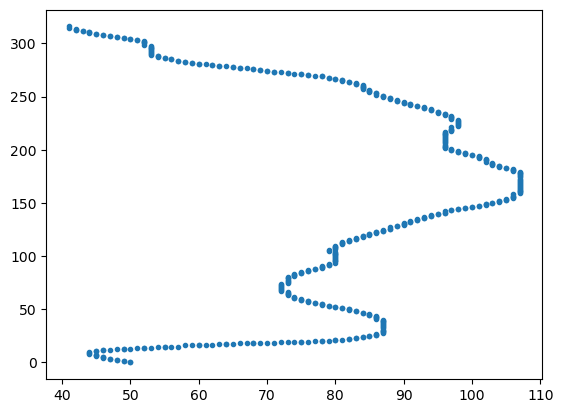

In [11]:
plt.plot(x_contour, y_contour, '.');


In [12]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)


In [13]:
x_contour, y_contour

([41,
  41,
  42,
  42,
  42,
  43,
  43,
  44,
  44,
  44,
  45,
  45,
  46,
  46,
  47,
  47,
  48,
  48,
  49,
  49,
  50,
  50,
  51,
  51,
  52,
  52,
  52,
  52,
  52,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  54,
  54,
  54,
  55,
  55,
  56,
  56,
  57,
  57,
  58,
  58,
  59,
  59,
  60,
  60,
  61,
  62,
  62,
  63,
  63,
  64,
  65,
  65,
  66,
  66,
  67,
  68,
  68,
  69,
  69,
  70,
  70,
  71,
  71,
  72,
  73,
  73,
  74,
  75,
  75,
  76,
  76,
  77,
  78,
  78,
  79,
  79,
  80,
  80,
  81,
  81,
  81,
  82,
  82,
  83,
  83,
  83,
  84,
  84,
  84,
  84,
  84,
  84,
  85,
  85,
  85,
  85,
  86,
  86,
  86,
  87,
  87,
  87,
  88,
  88,
  88,
  89,
  89,
  89,
  90,
  90,
  90,
  91,
  91,
  91,
  92,
  92,
  93,
  93,
  93,
  94,
  94,
  94,
  95,
  95,
  95,
  96,
  96,
  96,
  97,
  97,
  97,
  97,
  97,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  97,
  97,
  97,
  97,
  97,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96

In [14]:
diff_x_contour, diff_y_contour

(array([ 0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,
         1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
         0,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,
         0,  1,  0,  1,  0,  1,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,
         0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
         0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [15]:
# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)


In [16]:
#if both diff_y_contour and diff_x_contour == 0, means duplicate point
diff_ind

[3,
 5,
 7,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 25,
 31,
 40,
 43,
 45,
 47,
 49,
 51,
 53,
 56,
 58,
 61,
 63,
 66,
 68,
 70,
 72,
 75,
 78,
 80,
 83,
 85,
 87,
 89,
 92,
 95,
 99,
 104,
 107,
 110,
 113,
 117,
 120,
 122,
 125,
 128,
 131,
 133,
 136,
 140,
 153,
 158,
 171,
 175,
 178,
 180,
 183,
 186,
 190,
 194,
 197,
 200,
 203,
 207,
 225,
 231,
 235,
 237,
 240,
 242,
 245,
 247,
 249,
 251,
 253,
 256,
 258,
 261,
 264,
 267,
 270,
 273,
 276,
 279,
 282,
 284,
 287,
 290,
 294,
 297,
 300,
 304,
 312,
 320,
 324,
 327,
 330,
 333,
 336,
 339,
 343,
 359,
 363,
 366,
 368,
 371,
 373,
 376,
 378,
 380,
 382,
 385,
 387,
 390,
 393,
 398,
 408,
 413,
 415,
 417,
 419,
 421,
 424,
 427,
 431,
 439,
 444,
 449,
 455,
 459,
 463,
 467,
 469,
 474,
 477,
 480,
 482,
 484,
 486]

In [17]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [18]:
x_contour, y_contour

([41,
  41,
  42,
  42,
  43,
  44,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  52,
  52,
  52,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  53,
  54,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  81,
  82,
  83,
  83,
  84,
  84,
  84,
  84,
  84,
  85,
  85,
  85,
  86,
  86,
  87,
  87,
  88,
  88,
  89,
  89,
  90,
  90,
  91,
  91,
  92,
  93,
  93,
  94,
  94,
  95,
  95,
  96,
  96,
  97,
  97,
  97,
  97,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  97,
  97,
  97,
  97,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  96,
  97,
  97,
  98,
  98,
  99,
  99,
  100,
  101,
  101,
  101,
  102,
  102,
  102,
  103,
  103,
  103,
  104,
  104,
  105,
  106,
  106,
  106,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,
  107,


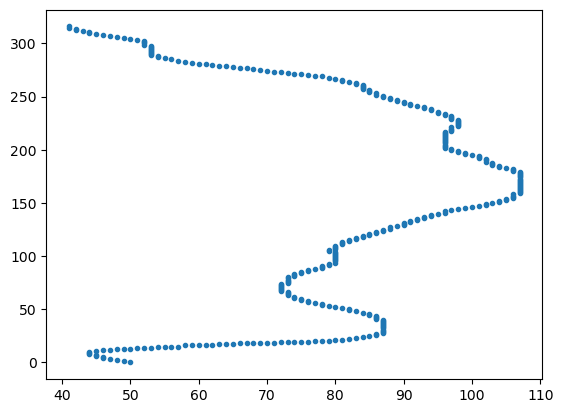

In [19]:
plt.plot(x_contour, y_contour, '.');

In [20]:
# Getting the bathymetry for the contour
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

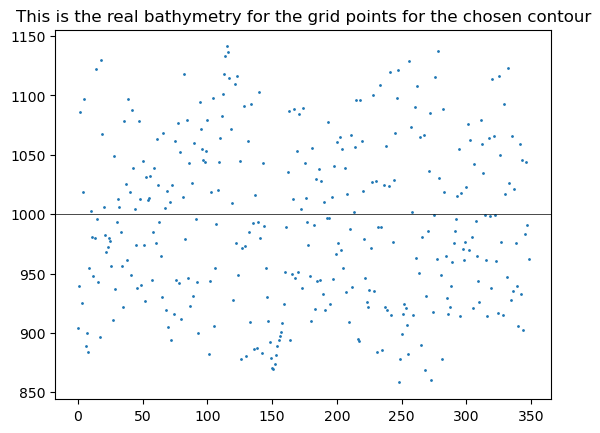

In [21]:
plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);
plt.title('This is the real bathymetry for the grid points for the chosen contour');

In [22]:
# Choose whether you want your contour on the u or t grid.
x_var = lon_rho
y_var = lat_rho

x_var, y_var


(<xarray.DataArray 'lon_rho' (eta_rho: 317, xi_rho: 272)>
 [86224 values with dtype=float64]
 Coordinates:
     lon_rho  (eta_rho, xi_rho) float64 ...
     lat_rho  (eta_rho, xi_rho) float64 ...
 Dimensions without coordinates: eta_rho, xi_rho
 Attributes:
     long_name:      longitude of RHO-points
     units:          degree_east
     standard_name:  longitude
     field:          lon_rho, scalar,
 <xarray.DataArray 'lat_rho' (eta_rho: 317, xi_rho: 272)>
 [86224 values with dtype=float64]
 Coordinates:
     lon_rho  (eta_rho, xi_rho) float64 ...
     lat_rho  (eta_rho, xi_rho) float64 ...
 Dimensions without coordinates: eta_rho, xi_rho
 Attributes:
     long_name:      latitude of RHO-points
     units:          degree_north
     standard_name:  latitude
     field:          lat_rho, scalar)

In [23]:
# # Getting lat and lon from the indexes
# lat_along_contour = np.zeros((len(x_contour)))
# lon_along_contour = np.zeros((len(x_contour)))

# # FS why do we need -1 here???
# for ii in range(len(h_contour)):
#     # print(ii-1)
#     # lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
#     # lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]
#     lon_along_contour[ii] = x_var[y_contour[ii],x_contour[ii]]
#     lat_along_contour[ii] = y_var[y_contour[ii],x_contour[ii]]    

In [24]:
# lon_along_contour, lat_along_contour 

In [25]:
# FS: My method. I think it is safer because I am informing the dimensions to be used, instead of selection columns...
lat_along_contour = list()
lon_along_contour = list()
for xx, yy in zip(x_contour, y_contour):
    lon_along_contour.append(x_var.isel(xi_rho=xx, eta_rho=yy).values)
    lat_along_contour.append(y_var.isel(xi_rho=xx, eta_rho=yy).values)


lon_along_contour, lat_along_contour

([array(153.93666372),
  array(153.920019),
  array(153.92807221),
  array(153.91142613),
  array(153.9194126),
  array(153.92732858),
  array(153.91068483),
  array(153.91853397),
  array(153.92631253),
  array(153.93402046),
  array(153.94165771),
  array(153.94922423),
  array(153.95671996),
  array(153.96414486),
  array(153.97149888),
  array(153.95487972),
  array(153.93825555),
  array(153.92162637),
  array(153.92892059),
  array(153.91229011),
  array(153.8956546),
  array(153.87901405),
  array(153.86236845),
  array(153.84571778),
  array(153.82906203),
  array(153.81240119),
  array(153.79573524),
  array(153.77906419),
  array(153.78632121),
  array(153.76964882),
  array(153.77683858),
  array(153.78390974),
  array(153.79099522),
  array(153.79809508),
  array(153.80520938),
  array(153.81233818),
  array(153.83612703),
  array(153.84328104),
  array(153.85044968),
  array(153.87426152),
  array(153.88145559),
  array(153.88866444),
  array(153.91249939),
  array(153.919

In [26]:
# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)
# FS: is this the same approach for my contour orientation??
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [27]:
lat_along_contour

array([-25.47414036, -25.51648937, -25.56694911, -25.60929812,
       -25.65973012, -25.71013438, -25.75248339, -25.8028599 ,
       -25.85320866, -25.90352968, -25.95382295, -26.00408848,
       -26.05432627, -26.10453631, -26.1547186 , -26.19706762,
       -26.23941663, -26.28176564, -26.33192019, -26.3742692 ,
       -26.41661822, -26.45896723, -26.50131624, -26.54366525,
       -26.58601427, -26.62836328, -26.67071229, -26.7130613 ,
       -26.76318811, -26.80553712, -26.85563618, -26.90569208,
       -26.95574799, -27.00580389, -27.05585979, -27.10591569,
       -27.11362258, -27.16367849, -27.21373439, -27.22144128,
       -27.27149718, -27.32155308, -27.32925997, -27.37931587,
       -27.42937178, -27.47942768, -27.52948358, -27.53719047,
       -27.58724637, -27.63730228, -27.64500917, -27.69506507,
       -27.74512097, -27.75282786, -27.80288376, -27.85293967,
       -27.90299557, -27.94534458, -27.99540048, -28.04545638,
       -28.0878054 , -28.1378613 , -28.18021031, -28.22

In [28]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

for ii, ii2 in zip(range(0, num_points-1), range(num_points-2, 0, -1)):
    contour_mask[y_contour[ii2], x_contour[ii2]] = contour_mask_numbered[ii]+1

contour_mask_numbered = contour_mask

### <span style="color: yellow;">Trying to understand the discontinuity of numbered mask when stacked and dropped the values undesired </span>

<span style="color:red"> Attention, FS 17th Jan 24 in the process to change the orientation of numbering, to be in agreement with domain orientation. Therefore, the figure below is outdated</span>

<img src="information_numbering.jpeg" alt="Alt Text" height="500">


In [29]:
# To show that we have numbered cells more than once per row
for vv in np.arange(-50, -40):
    # print(vv)
    print(contour_mask_numbered.isel(eta_rho=vv).values)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 294.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [30]:
# To show the discontinuity when stacked
contour_mask_numbered.where(contour_mask_numbered > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values[-50:-40]

array([300., 299., 301., 303., 302., 304., 305., 306., 308., 307.])

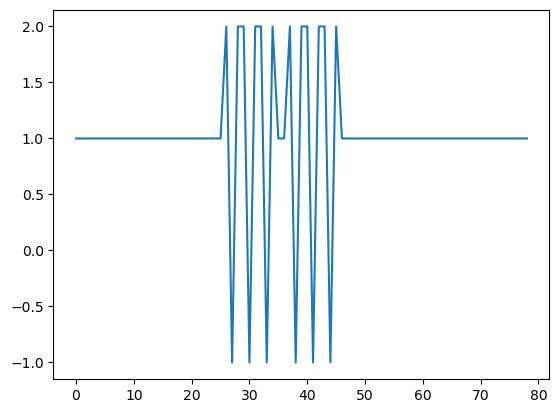

In [31]:
# To show the discontinuity as a plot
plt.plot(np.diff(contour_mask_numbered.where(contour_mask_numbered > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values[-80:]))

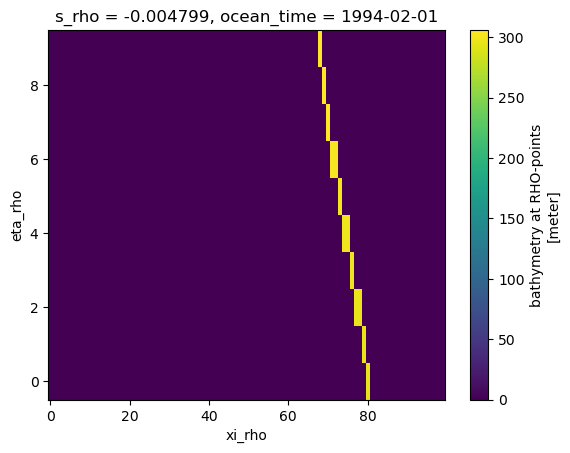

In [32]:
# It does not help much, but it shows the discontinuity...
contour_mask_numbered.isel(eta_rho=slice(-50, -40), xi_rho=slice(0, 100)).plot()

### <span style="color: cyan">Back to the processing...</span>

In [33]:
contour_mask_numbered[0], contour_mask_numbered[-2]

(<xarray.DataArray 'h' (xi_rho: 272)>
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Text(0.5, 1.0, 'Contour numbered')

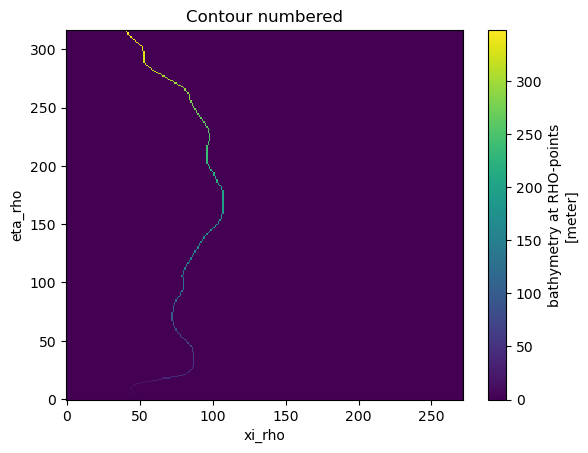

In [34]:
contour_mask_numbered.plot()
plt.title('Contour numbered')

#### <span style="color: yellow">To check the addition of one cell of value -1000 to start the process of masking</span>

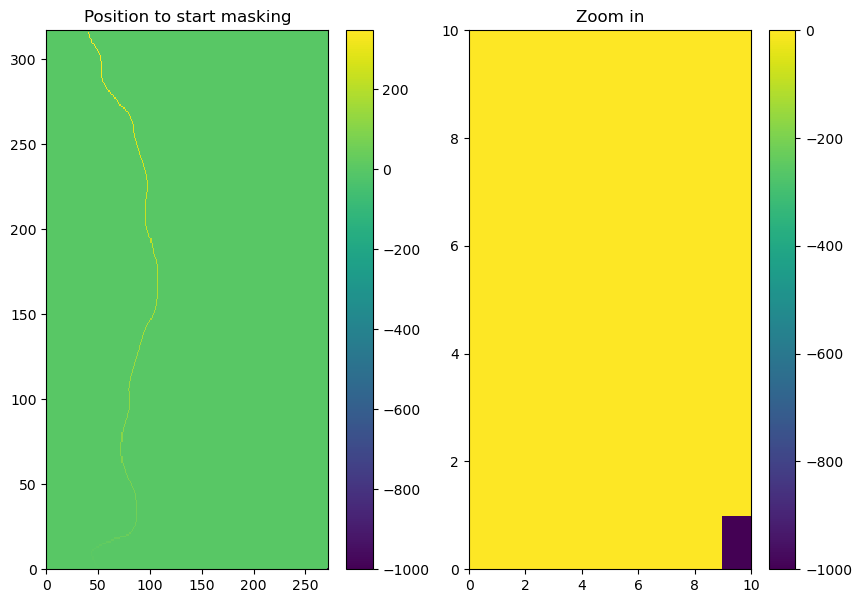

In [35]:
# FS to see what happens here
mask_value = -1000
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[0, -1] = mask_value

fig, ax = plt.subplots(ncols=2, figsize=(10, 7))
pco = ax[0].pcolor(contour_masked_above)
plt.colorbar(pco)
ax[0].set_title('Position to start masking');

pco = ax[1].pcolor(contour_masked_above[:10, -10:])
plt.colorbar(pco)
ax[1].set_title('Zoom in');

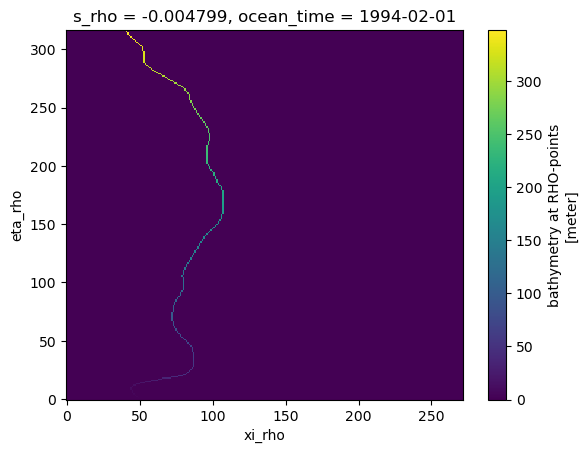

In [36]:
contour_mask.plot();

In [37]:
contour_masked_above[-10:, -10:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

#### <span style="color: cyan">Getting back to the analysis...</span>

In [38]:
#Create mask: This part starts from where in the four corners its found the MASK_VALUE. Once it is found, during the same loop that it is found, more MASK_VALUE are added to the CONTOUR_MASKED_ABOVE matrix. In this way, the mask expands every loop, adding more MASK_VALUE around the cell that it is already known to be masked. (interesting method)

# fill in one cell to the top east of the contour with value mask_value:I want offshore waters to be == -1000 and landward to be == 0
mask_value = -1000
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[0, -1] = mask_value

# The next loops will check the masks numbers (-1000 or 0) starting from
# the four corners of the domain. The one that will actually do all the work
# for my domain (FS speaking) is "from bottom right".

# from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:, 0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if west of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

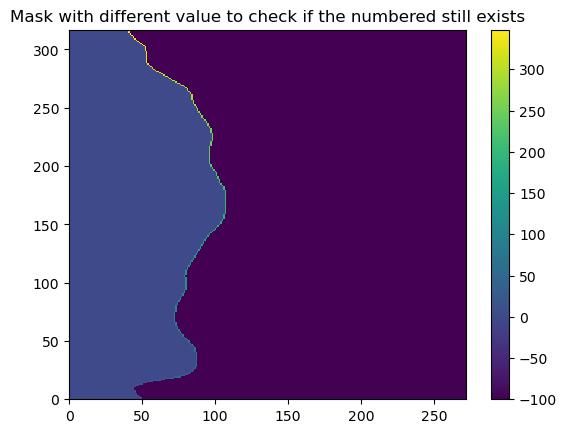

In [39]:
# FS just changing the filling value to check the numbered contour...created a temporary variable for that
contour_masked_above_tmp = np.where(contour_masked_above !=-1000, contour_masked_above, -100)
plt.pcolor(contour_masked_above_tmp)
plt.colorbar()
plt.title('Mask with different value to check if the numbered still exists');

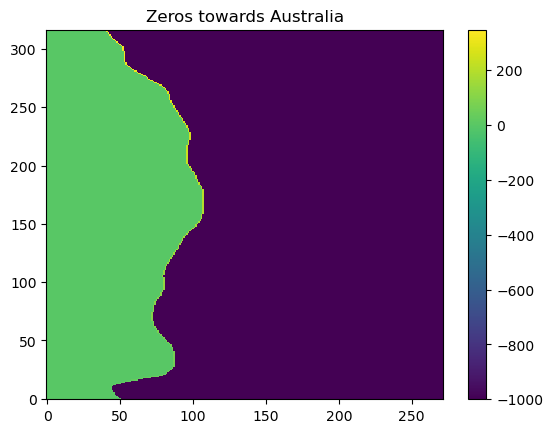

In [40]:
#FS and this is the original. Zeroes are towards Australia
plt.pcolormesh(contour_mask.xi_rho, contour_mask.eta_rho, contour_masked_above)
plt.colorbar();
plt.title('Zeros towards Australia');

In [41]:
# make halos: add 2 extra rows with the value of the last/first columns of the original
# The halo matrix has to be created according with your domain orientation.
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, 0]  # Inverted this one
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, -1] # with this one!

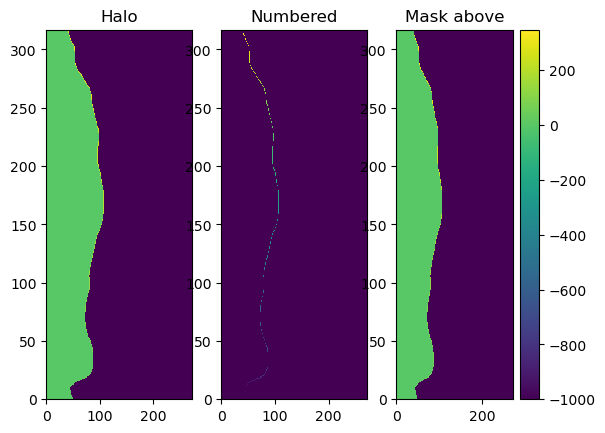

In [42]:
fig, ax = plt.subplots(ncols=3)
ax[0].pcolor(contour_masked_above_halo); ax[0].set_title('Halo');
ax[1].pcolor(contour_mask_numbered); ax[1].set_title('Numbered');
pc = ax[2].pcolor(contour_masked_above); plt.colorbar(pc)
ax[2].set_title('Mask above');

### <span style="color: yellow">Proving that the missing cells  in X and Y is a matter of size figure arctifact. All cells are numbered!</span>

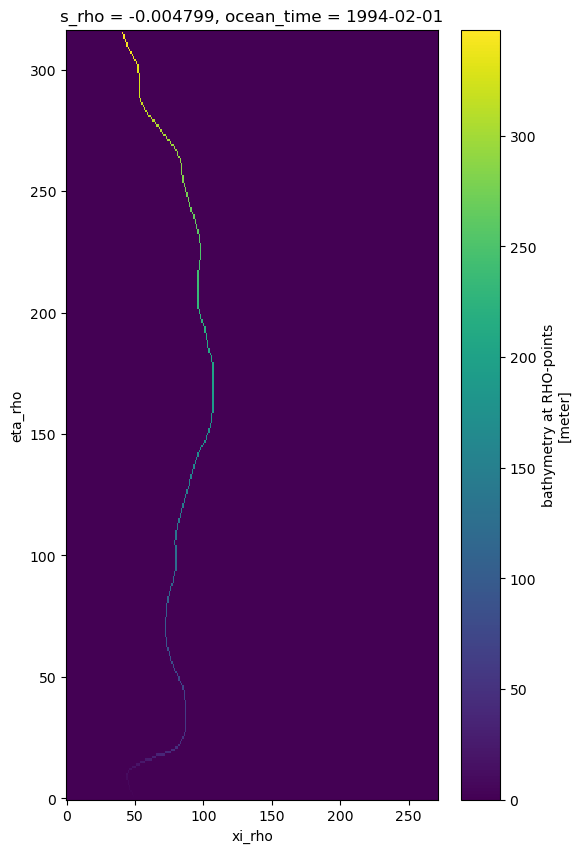

In [43]:
# To confirm that for CONTOUR_MASK_NUMBERED gaps from the figure above are just a plot window size arctifact, and the values does exist.
fig, ax = plt.subplots(figsize=(6, 10))
contour_mask_numbered.plot(ax=ax);

### <span style="color: cyan">Back to the processing...</span>

In [44]:
# To see how mask numbered and indexes behave together
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    print(mask_loc, index_j, index_i)

1 [0] [50]
2 [1] [49]
3 [2] [48]
4 [3] [47]
5 [4] [46]
6 [5] [46]
7 [6] [45]
8 [7] [45]
9 [8] [44]
10 [9] [44]
11 [10] [44]
12 [11] [45]
13 [12] [46]
14 [12] [47]
15 [13] [48]
16 [13] [49]
17 [13] [50]
18 [14] [51]
19 [14] [52]
20 [14] [53]
21 [15] [54]
22 [15] [55]
23 [15] [56]
24 [15] [57]
25 [16] [58]
26 [16] [59]
27 [16] [60]
28 [16] [61]
29 [16] [62]
30 [17] [63]
31 [17] [64]
32 [17] [65]
33 [18] [66]
34 [18] [67]
35 [18] [68]
36 [18] [69]
37 [18] [70]
38 [18] [71]
39 [19] [72]
40 [19] [73]
41 [19] [74]
42 [19] [75]
43 [19] [76]
44 [20] [77]
45 [20] [78]
46 [20] [79]
47 [21] [80]
48 [21] [81]
49 [22] [82]
50 [23] [83]
51 [24] [84]
52 [25] [85]
53 [26] [86]
54 [27] [86]
55 [28] [87]
56 [29] [87]
57 [30] [87]
58 [31] [87]
59 [32] [87]
60 [33] [87]
61 [34] [87]
62 [35] [87]
63 [36] [87]
64 [37] [87]
65 [38] [87]
66 [39] [87]
67 [40] [87]
68 [41] [86]
69 [42] [86]
70 [43] [86]
71 [44] [86]
72 [45] [85]
73 [46] [85]
74 [47] [84]
75 [48] [83]
76 [49] [82]
77 [50] [82]
78 [51] [81]
79 [5

#### <span style="color:yellow"> Understanding how the orientation of the mask are found </span>

In [45]:
# Saving pieces of the contour to check the complexity
for row in range(0, contour_mask_numbered.eta_rho.max().values-10):
    print(row)
    # Getting the number limits
    tmp = contour_mask_numbered.isel(eta_rho=slice(row, row + 10), xi_rho=slice(20, 130))
    numbers = tmp.where(tmp > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values
    vmin = np.min(numbers)
    vmax = np.max(numbers)
    fig, ax = plt.subplots()
    tmp.where(tmp > 0).plot(vmin=vmin, vmax=vmax)
    plt.savefig(f'check_contour_{row}.png')
    plt.close()


0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


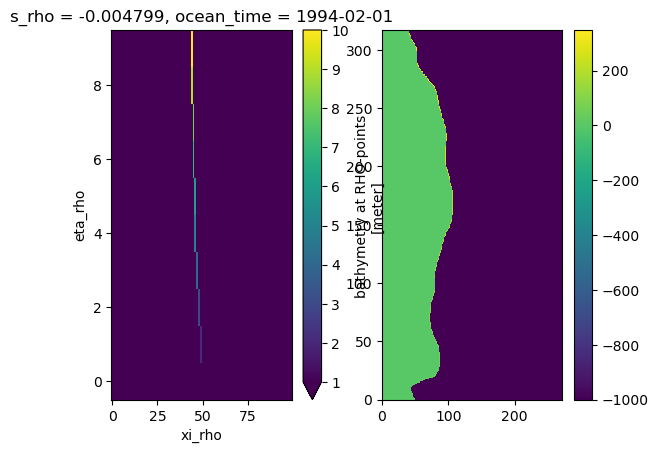

In [46]:
# Looking closer the bit by bit of the numbered mask being analysed
fig, ax = plt.subplots(ncols=2)

# This matrix is all zeros but the contour, which has increasing numbering
contour_mask_numbered.isel(eta_rho=slice(0, 10), xi_rho=slice(0, 100)).plot(ax=ax[0], vmin=1, vmax=10);

# This matrix has -1000 values OFFSHORE and 0 to the LAND side, and contour is numbered as well.
pco = ax[1].pcolor(contour_masked_above); plt.colorbar(pco)


#### <span style="color: cyan"> Going back to the analysis </span>

In [47]:
int(np.max(contour_mask_numbered))

348

In [48]:
# This part is to check the cell orientation.

# make halos: add 2 extra rows with the value of the last/first columns of the original
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0]+2, shape[1]))
# FS: is this line the opposite? I think it has to be to avoid same numbered to be reconized
contour_masked_above_halo[0, :] = contour_masked_above[-1, :]  
contour_masked_above_halo[1:-1, :] = contour_masked_above
# FS: is this line the opposite?
contour_masked_above_halo[-1, :] = contour_masked_above[0, :] 


# Direction of cross-contour transport
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)


new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):

    # Finding the 
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    print('Mask numbered number= %s' % mask_loc)
    print('For the index_j: %s, and index_i: %s' % (index_j, index_i))
    
    # Transport in U
    if (contour_masked_above[index_j, index_i+1]==0) and (contour_masked_above[index_j, index_i-1]!=0):
        print('Into x: %s' % new_number_count)
        mask_x_transport[index_j, index_i] = -1
        # important to do 
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    
    #
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]!=0):
        print('Into x: %s' % new_number_count)
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

    
    
    # # if point below and point above are BOTH towards Antarctica:
    # # take transport grid point to south of t grid:
    # elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]==0):
    #     mask_x_transport[index_j, index_i-1] = 1
    #     mask_x_transport[index_j, index_i] = -1        
    #     mask_x_transport_numbered[index_j, index_i-1] = new_number_count
    #     mask_x_transport_numbered[index_j, index_i] = new_number_count+1
    #     new_number_count += 2
    
    
    # Transport in V (+2 because we are using Halo and so to keep it consistant with the indexes)
    if (contour_masked_above_halo[index_j+2, index_i]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        print('Into y: %s' % new_number_count)
        mask_y_transport[index_j, index_i] = -1
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        print('ONE\n')

    # 
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j+2, index_i]!=0):
        print('Into y: %s' % new_number_count)
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
        print('TWO\n')


    # # if point to left and right BOTH toward Antarctica
    # elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j+2, index_i]==0):
    #     mask_y_transport[index_j-1, index_i] = 1
    #     mask_y_transport[index_j, index_i] = -1        
    #     mask_y_transport_numbered[index_j-1, index_i] = new_number_count
    #     mask_y_transport_numbered[index_j, index_i] = new_number_count+1
    #     new_number_count += 2

Mask numbered number= 1
For the index_j: [0], and index_i: [50]
Into x: 1
Mask numbered number= 2
For the index_j: [1], and index_i: [49]
Into x: 2
Into y: 3
TWO

Mask numbered number= 3
For the index_j: [2], and index_i: [48]
Into x: 4
Into y: 5
TWO

Mask numbered number= 4
For the index_j: [3], and index_i: [47]
Into x: 6
Into y: 7
TWO

Mask numbered number= 5
For the index_j: [4], and index_i: [46]
Into x: 8
Into y: 9
TWO

Mask numbered number= 6
For the index_j: [5], and index_i: [46]
Into x: 10
Mask numbered number= 7
For the index_j: [6], and index_i: [45]
Into x: 11
Into y: 12
TWO

Mask numbered number= 8
For the index_j: [7], and index_i: [45]
Into x: 13
Mask numbered number= 9
For the index_j: [8], and index_i: [44]
Into x: 14
Into y: 15
TWO

Mask numbered number= 10
For the index_j: [9], and index_i: [44]
Into x: 16
Mask numbered number= 11
For the index_j: [10], and index_i: [44]
Into x: 17
Into y: 18
ONE

Mask numbered number= 12
For the index_j: [11], and index_i: [45]
Int

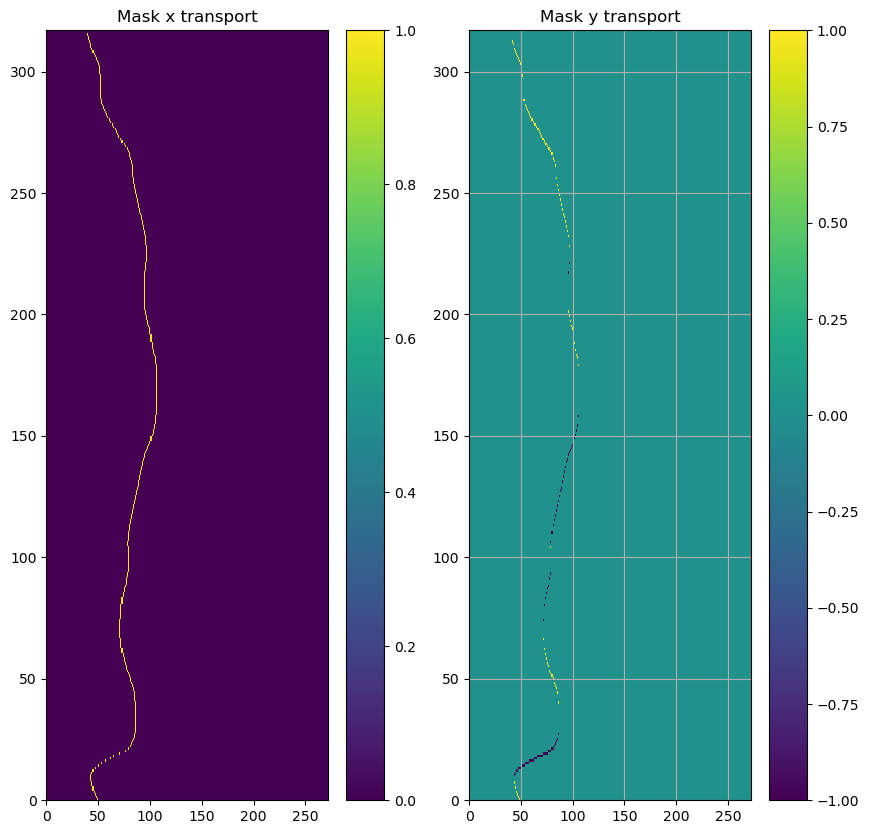

In [49]:
# Becarefull with the window size arctifact that avoid some cells to be added to the mask, leaving a gap that actually does not exist. With a better window size, we avoid that. This is specially for the xtransport.
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax0 = ax[0].pcolor(mask_x_transport);plt.colorbar(ax0); ax[0].set_title('Mask x transport');
ax1 = ax[1].pcolor(mask_y_transport); plt.colorbar(ax1); plt.grid(True); ax[1].set_title('Mask y transport');

#### <span style="color: yellow"> Plotting transport masks for X and Y together with the numbered mask to understand the orientation chosen</span>

In [50]:
# Saving pieces of the contour to check the complexity
for row in range(0, contour_mask_numbered.eta_rho.max().values-8):
    print(row)

    # Converting to DataArray
    tmp_contour_masked_above = xr.DataArray(contour_masked_above, dims=('eta_rho', 'xi_rho'))
    tmp_contour_masked_above_halo = xr.DataArray(contour_masked_above_halo, dims=('eta_rho', 'xi_rho'))


    # Getting the number limits
    tmp = tmp_contour_masked_above.isel(eta_rho=slice(row, row + 10), xi_rho=slice(20, 130))
    numbers = tmp.where(tmp > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values
    vmin = np.min(numbers)
    vmax = np.max(numbers)

    tmp_halo = tmp_contour_masked_above_halo.isel(eta_rho=slice(row, row + 10), xi_rho=slice(20, 130))
    numbers = tmp_halo.where(tmp_halo > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values
    vmin_halo = np.min(numbers)
    vmax_halo = np.max(numbers)

    # Converting the mask_X/Y_transport into DataArray.
    mask_transpX = xr.DataArray(mask_x_transport, dims=('eta_rho', 'xi_rho'), coords={'lat_rho': lat_rho, 'lon_rho': lon_rho})
    mask_transpY = xr.DataArray(mask_y_transport, dims=('eta_rho', 'xi_rho'), coords={'lat_rho': lat_rho, 'lon_rho': lon_rho})

    tmp_transp_x = mask_transpX.isel(eta_rho=slice(row, row + 10), xi_rho=slice(20, 130))
    tmp_transp_y = mask_transpY.isel(eta_rho=slice(row, row + 10), xi_rho=slice(20, 130))

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(5, 4))
    plot1= tmp.where(tmp > 0).plot(ax=ax[0, 0], vmin=vmin, vmax=vmax); ax[0, 0].set_title('Mask Numbered'); ax[0, 0].grid(); ax[0, 0].set_xlabel(''); ax[0, 0].set_xticklabels([])
    plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])
    
    plot3 = tmp_transp_x.plot(ax=ax[1, 0], vmin=-1, vmax=1, cmap='RdBu'); ax[1, 0].set_title('Mask_transp X'); ax[1, 0].grid(); ax[1, 0].set_xlabel(''); ax[1, 0].set_xticklabels('')
    plot4 = tmp_transp_y.plot(ax=ax[1, 1], vmin=-1, vmax=1, cmap='RdBu'); ax[1, 1].set_title('Mask_transp Y'); ax[1, 1].grid(); ax[1, 1].set_xlabel(''); ax[1, 1].set_xticklabels('')
    
    plot1.colorbar.set_label('')
    plot2.colorbar.set_label('')
    plot3.colorbar.set_label('')
    plot4.colorbar.set_label('')


    plt.savefig(f'check_contour_masks_{row}.png', dpi=250, bbox_inches='tight')
    plt.close()


0


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


1


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


2


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


3


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


4


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


5


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


6


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


7


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


8


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


9


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


10


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


11


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


12


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


13


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


14


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


15


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


16


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


17


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


18


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


19


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


20


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


21


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


22


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


23


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


24


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


25


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


26


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


27


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


28


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


29


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


30


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


31


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


32


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


33


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


34


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


35


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


36


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


37


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


38


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


39


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


40


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


41


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


42


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


43


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


44


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


45


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


46


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


47


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


48


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


49


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


50


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


51


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


52


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


53


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


54


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


55


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


56


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


57


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


58


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


59


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


60


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


61


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


62


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


63


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


64


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


65


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


66


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


67


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


68


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


69


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


70


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


71


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


72


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


73


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


74


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


75


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


76


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


77


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


78


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


79


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


80


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


81


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


82


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


83


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


84


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


85


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


86


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


87


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


88


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


89


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


90


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


91


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


92


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


93


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


94


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


95


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


96


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


97


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


98


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


99


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


100


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


101


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


102


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


103


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


104


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


105


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


106


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


107


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


108


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


109


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


110


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


111


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


112


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


113


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


114


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


115


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


116


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


117


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


118


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


119


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


120


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


121


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


122


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


123


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


124


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


125


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


126


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


127


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


128


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


129


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


130


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


131


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


132


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


133


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


134


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


135


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


136


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


137


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


138


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


139


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


140


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


141


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


142


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


143


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


144


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


145


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


146


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


147


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


148


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


149


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


150


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


151


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


152


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


153


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


154


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


155


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


156


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


157


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


158


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


159


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


160


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


161


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


162


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


163


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


164


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


165


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


166


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


167


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


168


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


169


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


170


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


171


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


172


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


173


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


174


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


175


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


176


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


177


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


178


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


179


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


180


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


181


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


182


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


183


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


184


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


185


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


186


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


187


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


188


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


189


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


190


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


191


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


192


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


193


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


194


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


195


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


196


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


197


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


198


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


199


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


200


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


201


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


202


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


203


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


204


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


205


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


206


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


207


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


208


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


209


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


210


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


211


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


212


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


213


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


214


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


215


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


216


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


217


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


218


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


219


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


220


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


221


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


222


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


223


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


224


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


225


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


226


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


227


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


228


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


229


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


230


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


231


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


232


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


233


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


234


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


235


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


236


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


237


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


238


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


239


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


240


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


241


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


242


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


243


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


244


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


245


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


246


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


247


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


248


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


249


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


250


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


251


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


252


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


253


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


254


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


255


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


256


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


257


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


258


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


259


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


260


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


261


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


262


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


263


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


264


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


265


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


266


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


267


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


268


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


269


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


270


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


271


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


272


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


273


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


274


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


275


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


276


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


277


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


278


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


279


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


280


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


281


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


282


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


283


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


284


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


285


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


286


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


287


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


288


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


289


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


290


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


291


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


292


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


293


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


294


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


295


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


296


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


297


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


298


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


299


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


300


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


301


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


302


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


303


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


304


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


305


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


306


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


307


/tmp/ipykernel_310/1349037282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])


In [51]:
# # Converting to DataArray
# tmp_contour_masked_above = xr.DataArray(contour_masked_above, dims=('eta_rho', 'xi_rho'))
# tmp_contour_masked_above_halo = xr.DataArray(contour_masked_above_halo, dims=('eta_rho', 'xi_rho'))


# # Getting the number limits
# tmp = tmp_contour_masked_above.isel(eta_rho=slice(8, 8+10), xi_rho=slice(20, 80))
# numbers = tmp.where(tmp > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values
# vmin = np.min(numbers)
# vmax = np.max(numbers)

# tmp_halo = tmp_contour_masked_above_halo.isel(eta_rho=slice(8, 8+10), xi_rho=slice(20,80))
# numbers = tmp_halo.where(tmp_halo > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values
# vmin_halo = np.min(numbers)
# vmax_halo = np.max(numbers)

# # Converting the mask_X/Y_transport into DataArray.
# mask_transpX = xr.DataArray(mask_x_transport, dims=('eta_rho', 'xi_rho'), coords={'lat_rho': lat_rho, 'lon_rho': lon_rho})
# mask_transpY = xr.DataArray(mask_y_transport, dims=('eta_rho', 'xi_rho'), coords={'lat_rho': lat_rho, 'lon_rho': lon_rho})

# tmp_transp_x = mask_transpX.isel(eta_rho=slice(8, 8+10), xi_rho=slice(20, 80))
# tmp_transp_y = mask_transpY.isel(eta_rho=slice(8, 8+10), xi_rho=slice(20, 80))

# fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
# plot1= tmp.where(tmp > 0).plot(ax=ax[0, 0], vmin=vmin, vmax=vmax); ax[0, 0].set_title('Mask Numbered'); ax[0, 0].grid(); ax[0, 0].set_xlabel(''); ax[0, 0].set_xticklabels([])
# plot2= tmp_halo.where(tmp_halo > 0).plot(ax=ax[0, 1], vmin=vmin_halo, vmax=vmax_halo); ax[0, 1].set_title('Halo Mask Numbered'); ax[0, 1].grid(); ax[0, 1].set_xlabel(''); ax[0, 1].set_xticklabels([''])

# plot3 = tmp_transp_x.plot(ax=ax[1, 0], vmin=-1, vmax=1, cmap='RdBu'); ax[1, 0].set_title('Mask_transp X'); ax[1, 0].grid(); ax[1, 0].set_xlabel(''); ax[1, 0].set_xticklabels('')
# plot4 = tmp_transp_y.plot(ax=ax[1, 1], vmin=-1, vmax=1, cmap='RdBu'); ax[1, 1].set_title('Mask_transp Y'); ax[1, 1].grid(); ax[1, 1].set_xlabel(''); ax[1, 1].set_xticklabels('')

# plot1.colorbar.set_label('')
# plot2.colorbar.set_label('')
# plot3.colorbar.set_label('')
# plot4.colorbar.set_label('')

# # row=-10
# # plt.savefig(f'check_contour_masks_{row}.png', dpi=250, bbox_inches='tight')
# # plt.close()

In [52]:
# row = 250
# # Converting to DataArray
# tmp_contour_masked_above = xr.DataArray(contour_masked_above, dims=('eta_rho', 'xi_rho'))


# # Getting the number limits
# tmp = tmp_contour_masked_above.isel(eta_rho=slice(row, row + 10), xi_rho=slice(20, 130))
# numbers = tmp.where(tmp > 0).stack(h=('eta_rho', 'xi_rho')).dropna(dim='h').values
# vmin = np.min(numbers)
# vmax = np.max(numbers)

# tmp.plot(vmin=vmin, vmax=vmax)

#### <span style="color: cyan"> Going back to the analysis </span>

In [53]:
# fig, ax = plt.subplots(ncols=2, figsize=(8,6))
# ax0 = ax[0].pcolor(mask_x_transport);plt.colorbar(ax0); 
# ax1 = ax[1].pcolor(mask_y_transport); plt.colorbar(ax1); plt.grid(True)

In [54]:
print(pm.shape, pn.shape)

(317, 272) (317, 272)


In [55]:
# # This is Fabio's adaptation. It is his way of interpolation from rho to u/v grid

# import pyresample

# rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
# u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
# v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)


# wf = lambda r: 1/r

# mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)


# # Convert contour masks to data arrays, so we can multiply them later.
# # We need to ensure the lat lon coordinates correspond to the actual data location:
# # The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
# # The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
# # However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
# # to make concatenation of transports in both direction and sorting possible.
# coordinates=dict(one=lon_rho, two=lat_rho)
# coordinatesU=dict(one=lon_u, two=lat_u)
# coordinatesV=dict(one=lon_v, two=lat_v)


# mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
# mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])

# # rename dimensions as simply eta/xi
# mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
# mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})




In [56]:
# mask_x_transport_Ugrd.shape, mask_y_transport_Vgrd.shape 

In [57]:
# This is Fabio's adaptation. It is his way of interpolation from rho to u/v grid
# FS: this part differently from Fabios analysis, I adjusted to my diagnostic variables which are placed at rho points.
import pyresample

rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)


wf = lambda r: 1/r

mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered, rho_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)


# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
# The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
# The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
# However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
# to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)


# -->> For the use of the DIAGNOSTIC output <<--
mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinates, dims = ['eta_rho', 'xi_rho'])

# rename dimensions as simply eta/xi
mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_rho': 'eta','xi_rho': 'xi'})

In [58]:
mask_x_transport_Ugrd.shape, mask_y_transport_Vgrd.shape 

((317, 272), (317, 272))

In [59]:
mask_x_transport_Ugrd, mask_y_transport_Vgrd

(<xarray.DataArray (eta: 317, xi: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
     one      (eta, xi) float64 147.1 147.1 147.2 147.2 ... 162.1 162.2 162.2
     two      (eta, xi) float64 -38.5 -38.51 -38.52 ... -28.13 -28.15 -28.16
 Dimensions without coordinates: eta, xi,
 <xarray.DataArray (eta: 317, xi: 272)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
     one      (eta, xi) float64 147.1 147.1 147.2 147.2 ... 162.1 162.2 162.2
     two      (eta, xi) float64 -38.5 -38.51 -38.52 ... -28.13 -28.15 -28.16
 Dimensions without coordinates: eta, xi)

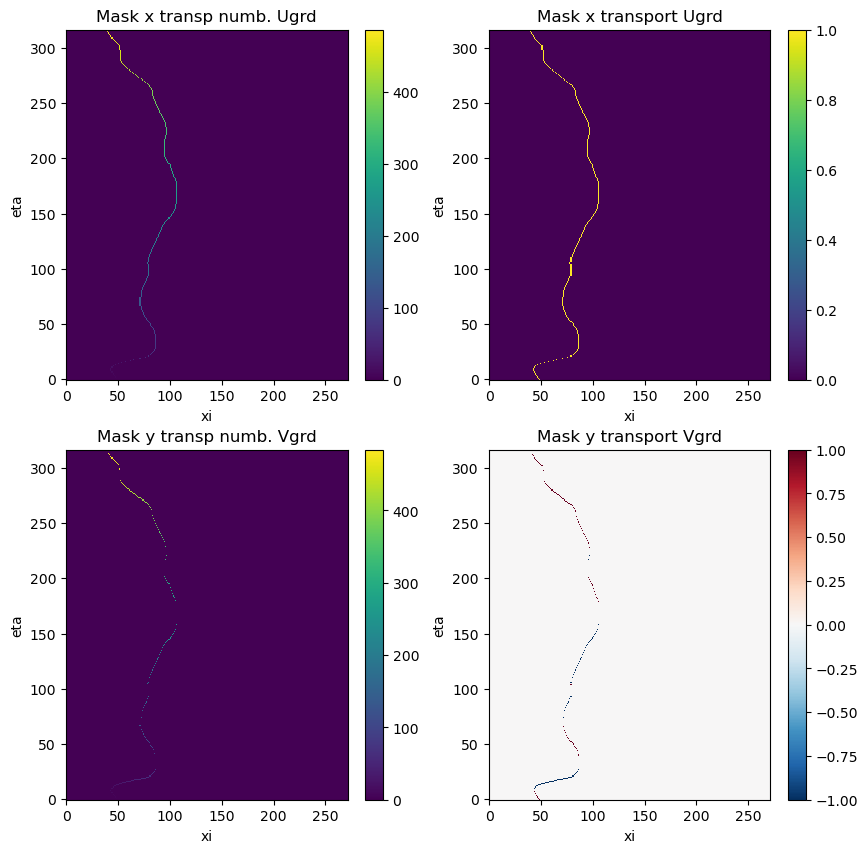

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
mask_x_transport_numbered_Ugrd.plot(ax=ax[0, 0]); ax[0,0].set_title('Mask x transp numb. Ugrd');
mask_x_transport_Ugrd.plot(ax=ax[0, 1]); ax[0,1].set_title('Mask x transport Ugrd');
mask_y_transport_numbered_Vgrd.plot(ax=ax[1, 0]); ax[1,0].set_title('Mask y transp numb. Vgrd');
mask_y_transport_Vgrd.plot(ax=ax[1, 1]); ax[1,1].set_title('Mask y transport Vgrd');

In [61]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
# dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
# *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
# but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
# FS: doing this we will get the (x, y) for the contour points as tuples
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True) # will remove all the zeros

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)  # will remove all the zeros

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [62]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                    eta_psi: 316, xi_psi: 271, ocean_time: 30)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 1994-02-01 ... 1994-03-02
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/139)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    salt_hdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_xdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_ydiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_sdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_vdiff     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt_rate      (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
Attributes: (12/34)
    file:              outer_dia.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS diagnostics file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

### <span style="color: cyan">Starting to test the X/Y transport masks with the DIAGNOSTIC output</span>

In [63]:
# Starting the test with the (bad) calculation of the HEAT TRANSPORT
# temp = ds.temp.isel(ocean_time=0)
# v = ds.v_northward.isel(ocean_time=0)
# u = ds.u_eastward.isel(ocean_time=0)

# FS: test for the diagnostic output.
temp_rate = ds.temp_rate.isel(ocean_time=0)
temp_xadv = ds.temp_xadv.isel(ocean_time=0)
temp_yadv = ds.temp_yadv.isel(ocean_time=0)
temp_vadv = ds.temp_vadv.isel(ocean_time=0)
temp_xdiff = ds.temp_xdiff.isel(ocean_time=0)
temp_ydiff = ds.temp_ydiff.isel(ocean_time=0)
temp_vdiff = ds.temp_vdiff.isel(ocean_time=0)
# volume = ds_metric.dx * ds_metric.dy * ds_metric.dz.isel(ocean_time=0)   # dz its varying in time due to the free surface


##### <span style="color: cyan">Comparing vertically integrated Temp tendency from model and as the sum of the terms</span>


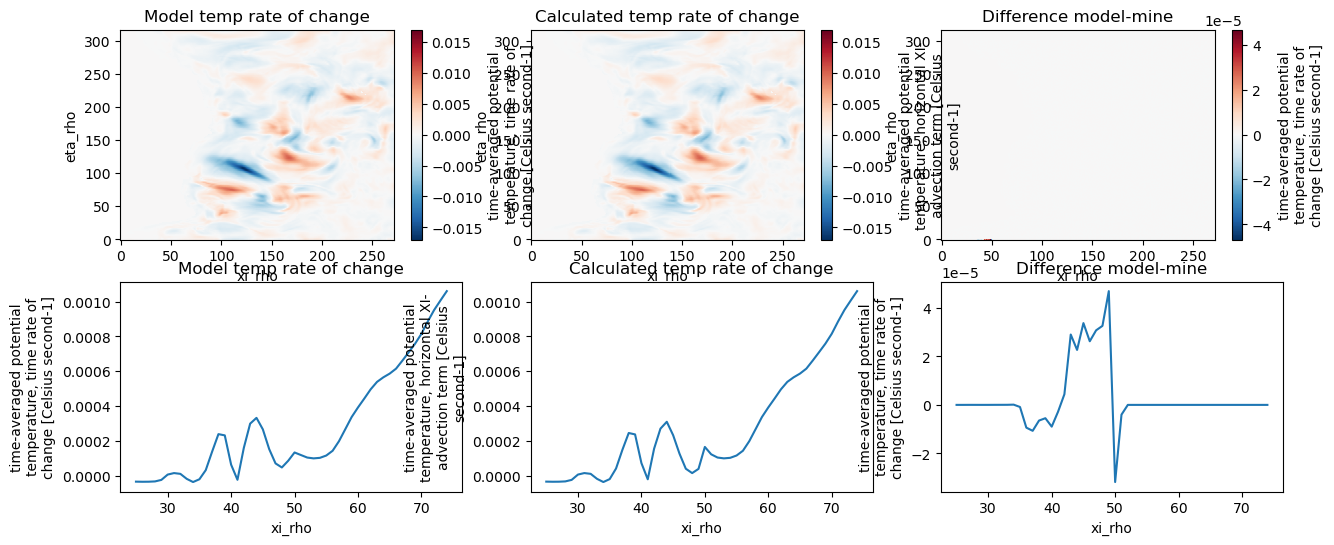

In [64]:

# Model vertical integral
dz = ds_metric.dz.isel(ocean_time=0)
int_temp_rate = (temp_rate * dz).sum('s_rho')

# My calculation vertically integrated
my_int_temp_rate = (temp_xadv * dz).sum('s_rho') + (temp_yadv * dz).sum('s_rho') + (temp_vadv * dz).sum('s_rho') + (temp_xdiff * dz).sum('s_rho') + (temp_ydiff * dz).sum('s_rho') + (temp_vdiff * dz).sum('s_rho')

# Plot comparing
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

# First row with maps
int_temp_rate.plot(ax=ax[0, 0]); ax[0, 0].set_title('Model temp rate of change');
my_int_temp_rate.plot(ax=ax[0, 1]); ax[0, 1].set_title('Calculated temp rate of change');
(int_temp_rate - my_int_temp_rate).plot(ax=ax[0, 2]); ax[0, 2].set_title('Difference model-mine');

# Second row looking closer to the only difference in the grid (it is just the first row that has this difference)
int_temp_rate.isel(xi_rho=slice(25, 75), eta_rho=slice(0, 1)).plot(ax=ax[1, 0]); ax[1, 0].set_title('Model temp rate of change');
my_int_temp_rate.isel(xi_rho=slice(25, 75), eta_rho=slice(0, 1)).plot(ax=ax[1, 1]); ax[1, 1].set_title('Calculated temp rate of change');
(int_temp_rate - my_int_temp_rate).isel(xi_rho=slice(25, 75), eta_rho=slice(0, 1)).plot(ax=ax[1, 2]); ax[1, 2].set_title('Difference model-mine');

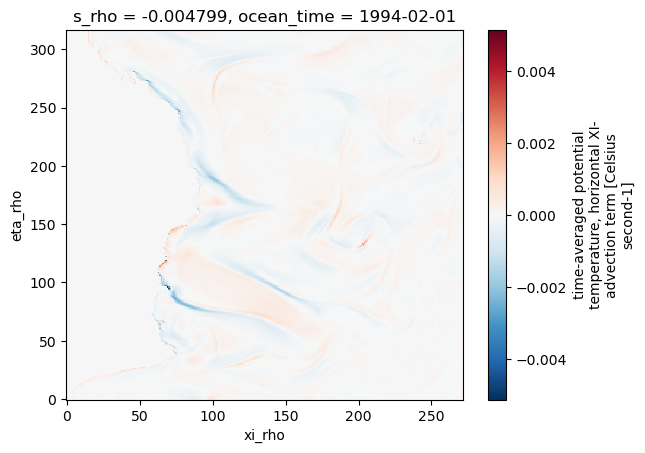

In [65]:
# To have a look into the magnitude
temp_xadv.isel(s_rho=-1).plot()

In [66]:
# # determine constants:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1


# # Bad calculation of heat transport, due to the use of rho points for temp when I have u/v in their origianl location!!!! FS
# v_heat_trans = (temp * v * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})
# u_heat_trans = (temp * u * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})


# # temporary while rho and u/v grid are not properly set
# u_heat_trans = u_heat_trans.isel(xi=slice(0, -1))
# v_heat_trans = v_heat_trans.isel(eta=slice(0, -1))



In [67]:
# fig, ax = plt.subplots(ncols=2)
# u_heat_trans.isel(s_rho=-1).plot(ax=ax[0]); ax[0].set_title('U Heat flux');
# v_heat_trans.isel(s_rho=-1).plot(ax=ax[1]); ax[1].set_title('V Heat flux');

In [68]:
mask_x_numbered_1d

<xarray.DataArray (contour_index: 316)>
array([  1.,   2.,   4.,   6.,   8.,  10.,  11.,  13.,  14.,  16.,  17.,
        19.,  21.,  24.,  28.,  32.,  37.,  43.,  47.,  54.,  60.,  64.,
        67.,  69.,  71.,  73.,  75.,  76.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  93.,  94.,
        95.,  96.,  98.,  99., 101., 103., 105., 106., 108., 110., 112.,
       114., 115., 117., 119., 120., 122., 123., 125., 126., 128., 129.,
       130., 131., 133., 134., 135., 136., 137., 138., 139., 141., 142.,
       143., 144., 145., 146., 148., 149., 150., 152., 153., 155., 156.,
       158., 160., 161., 162., 164., 165., 167., 168., 169., 170., 171.,
       172., 173., 174., 175., 176., 177., 178., 180., 182., 183., 184.,
       185., 187., 188., 189., 191., 192., 194., 195., 197., 198., 200.,
       201., 203., 204., 206., 207., 209., 210., 212., 214., 215., 216.,
       218., 219., 221., 222., 224., 225., 227., 228., 230., 232., 233.,
       235., 237., 239., 241., 243., 245., 246., 248., 250., 251., 253.,
       254., 256., 257., 258., 259., 261., 262., 263., 264., 265., 266.,
       267., 268., 269., 270., 271., 272., 273., 274., 275., 276., 277.,
       278., 279., 280., 281., 282., 284., 285., 286., 288., 290., 291.,
       293., 294., 295., 297., 298., 299., 301., 302., 303., 305., 307.,
       308., 310., 311., 313., 314., 316., 317., 318., 319., 320., 321.,
       322., 323., 324., 325., 326., 327., 328., 329., 330., 332., 333.,
       334., 335., 337., 338., 339., 340., 341., 342., 343., 344., 346.,
       347., 348., 349., 351., 352., 354., 355., 357., 358., 360., 361.,
       363., 365., 366., 368., 369., 371., 372., 374., 375., 377., 378.,
       380., 381., 383., 384., 385., 387., 388., 389., 390., 391., 393.,
       394., 396., 398., 399., 401., 404., 406., 409., 411., 414., 416.,
       418., 420., 423., 425., 428., 430., 433., 435., 437., 439., 441.,
       443., 445., 447., 448., 450., 451., 452., 453., 454., 455., 456.,
       457., 458., 459., 461., 462., 463., 464., 466., 468., 470., 472.,
       474., 476., 478., 480., 481., 483., 485., 486.])
Coordinates:
    one            (contour_index) float64 148.6 148.6 148.6 ... 153.9 153.9
    two            (contour_index) float64 -38.92 -38.87 ... -25.56 -25.51
  * contour_index  (contour_index) object MultiIndex
  * eta            (contour_index) int64 0 1 2 3 4 5 ... 310 311 312 313 314 315
  * xi             (contour_index) int64 49 48 47 46 45 45 ... 43 43 42 41 41 40

In [69]:
temp_xadv.shape, np.shape(mask_x_transport_Ugrd)

((30, 317, 272), (317, 272))

In [70]:
# fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
# u_heat_trans.isel(s_rho=-1).plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu'); ax[0].set_title('U Heat flux');

# for vv in mask_x_numbered_1d.contour_index.values:
#     ax[0].plot(vv[1], vv[0], 'ok', alpha=0.1);
# p1= ax[1].pcolor(u_heat_trans.isel(s_rho=-1) * mask_x_transport_Ugrd, vmin=-2e7, vmax=2e7, cmap='RdBu'); # u points
# plt.colorbar(p1); ax[1].set_title('Heat Flux with the mask x applied')

# p2 = ax[2].pcolor(mask_x_transport_Ugrd, cmap='bwr'); ax[2].set_title('Mask x applied'); # u points
# plt.colorbar(p2);

In [71]:
# fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
# v_heat_trans.isel(s_rho=-1).plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu'); ax[0].set_title('V Heat flux');
# for vv in mask_y_numbered_1d.contour_index.values:
#     ax[0].plot(vv[1], vv[0], 'ok', alpha=0.2);
# p1= ax[1].pcolor(v_heat_trans.isel(s_rho=-1) * mask_y_transport_Vgrd, vmin=-2e7, vmax=2e7, cmap='RdBu'); # v points
# plt.colorbar(p1); ax[1].set_title('Heat Flux with the mask y applied')
# p2 = ax[2].pcolor(mask_y_transport_Vgrd, cmap='bwr'); ax[2].set_title('Mask y applied');
# plt.colorbar(p2);

In [72]:

def extract_transp_across_contour(temp, var_x, var_y):   # var:4D [time,eta_rho,xi_rho]
    '''
    The input attributes:

    - temp: it is used here just to get the time dimension
    - var_x and var_y: it is the x and y wrt the variable being used, in my case temp_adv/temp_diff
    FS comment and a few adaptations.
    '''

    zlen = len(temp[:,0,0])
    tlen = 1
    # print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

    for tt in range(0,tlen): # loop through time
        for zz in range(0,zlen): # loop through z-levels

            print('Debugging high memory usage: ')
            print('Time: %s, and Sigma level: %s' % (tt, zz))

            # U and V points
            # var_x_tmp = var_x.isel(s_rho=zz) * mask_x_transport_Ugrd
            # var_y_tmp = var_y.isel(s_rho=zz) * mask_y_transport_Vgrd

            # In case you need to extract only the ".values" to avoid problem with memory... FS 11th jan 2024
            var_x_tmp = var_x.isel(s_rho=zz).values * mask_x_transport_Ugrd
            var_y_tmp = var_y.isel(s_rho=zz).values * mask_y_transport_Vgrd
            
            print('var_x_tmp/var_y_tmp shapes after mask multip.: %s, %s' % (var_x_tmp.shape, var_y_tmp.shape))
            
            # fig, ax = plt.subplots(ncols=2)
            # p0 = ax[0].pcolor(var_x_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p0)
            # p1 = ax[1].pcolor(var_y_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p1)

            # stack transports into 1d and drop any points not on contour:
            # 'CONTOUR_INDEX' keeps the (row, col) position, so even when you drop values, you have the location
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d > 0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d > 0, drop = True)

            print('x_var_1d_tmp/y_var_1d_tmp shapes after stack: %s, %s' % (x_var_1d_tmp.shape, y_var_1d_tmp.shape))

            # ORIGINAL combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()
          
            # print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour.squeeze()  # getting rid of unit dimention

#### <span style="color: yellow"> Testing the effect of the masking for the Temp Tendency terms</span>

Debugging high memory usage: 
Time: 0, and Sigma level: 0
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)


/tmp/ipykernel_310/3884071660.py:44: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array


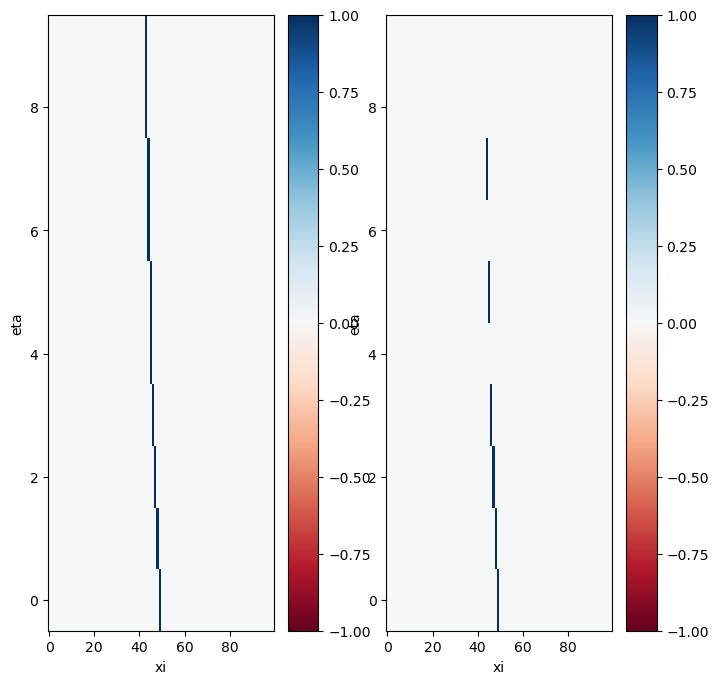

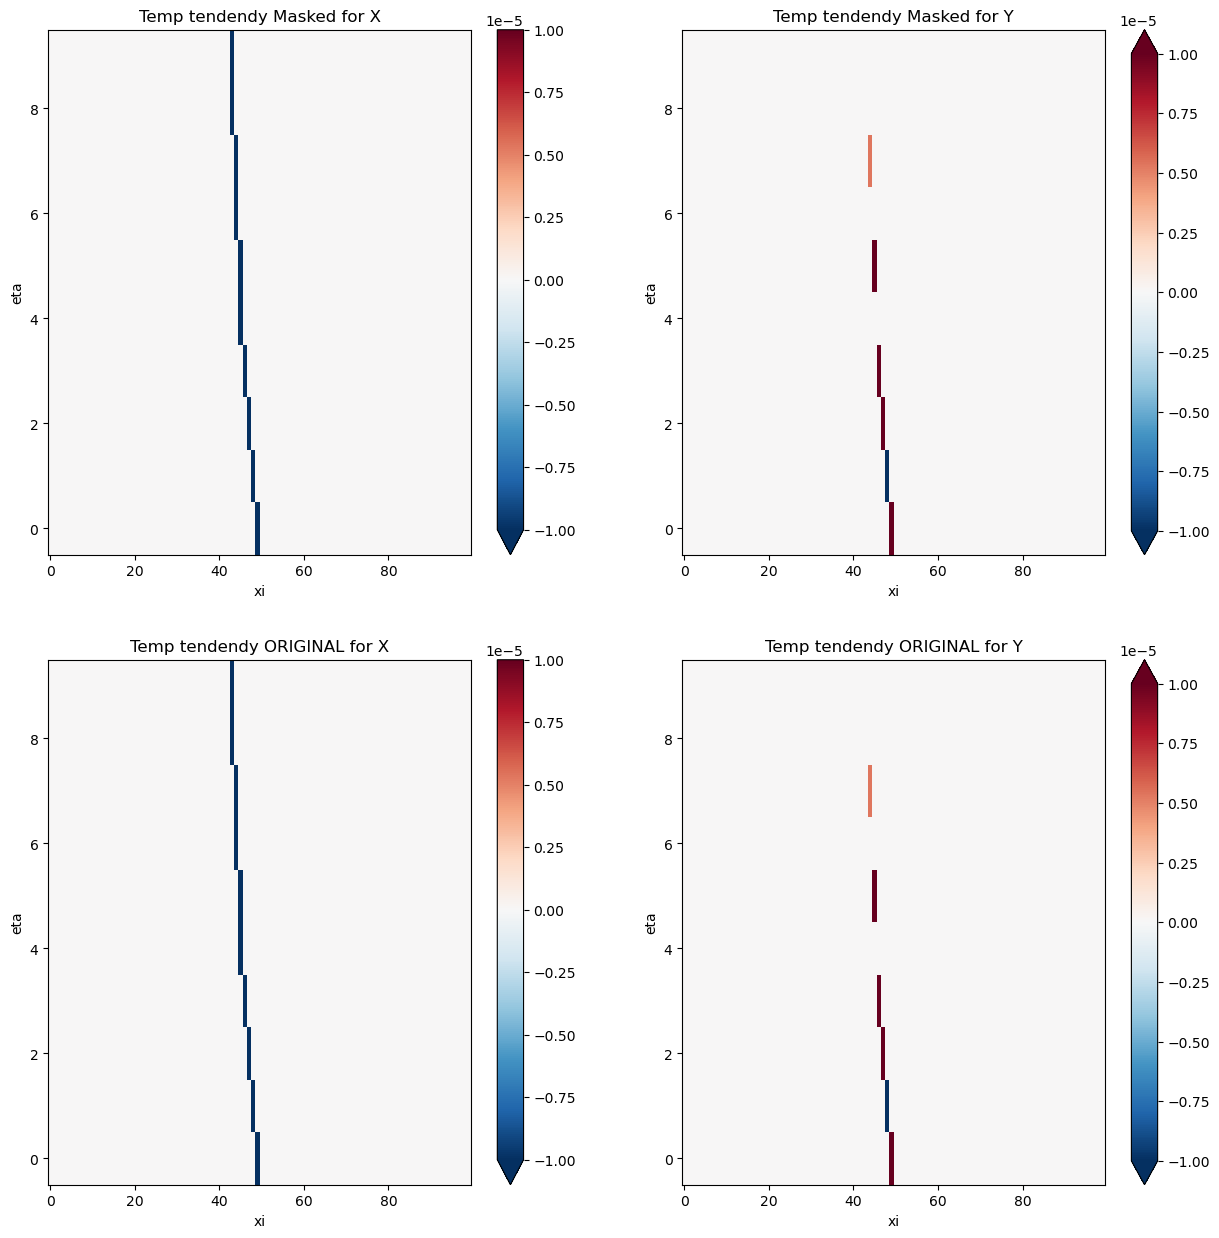

In [73]:
# Plotting the MASK_X_TRANSPORT/MASK_Y_TRANSPORT
fig, ax = plt.subplots(ncols=2, figsize=(8, 8))
mask_x_transport_Ugrd.isel(eta=slice(0, 10), xi=slice(0, 100)).plot(ax=ax[0], vmin=-1, vmax=1, cmap='RdBu')
mask_y_transport_Vgrd.isel(eta=slice(0, 10), xi=slice(0, 100)).plot(ax=ax[1], vmin=-1, vmax=1, cmap='RdBu')


var_x = temp_xadv + temp_xdiff
var_y = temp_yadv + temp_ydiff

tlen = 1
tt = 0
zlen = 1

transp_across_contour = np.zeros((tlen,zlen,len(contour_ordering)))

for zz in range(0, zlen): # loop through z-levels

    print('Debugging high memory usage: ')
    print('Time: %s, and Sigma level: %s' % (tt, zz))

    # In case you need to extract only the ".values" to avoid problem with memory... FS 11th jan 2024
    var_x_tmp = var_x.isel(s_rho=zz).values * mask_x_transport_Ugrd
    var_y_tmp = var_y.isel(s_rho=zz).values * mask_y_transport_Vgrd
    
    print('var_x_tmp/var_y_tmp shapes after mask multip.: %s, %s' % (var_x_tmp.shape, var_y_tmp.shape))
    
    # fig, ax = plt.subplots(ncols=2)
    # p0 = ax[0].pcolor(var_x_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p0)
    # p1 = ax[1].pcolor(var_y_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p1)

    # stack transports into 1d and drop any points not on contour:
    # 'CONTOUR_INDEX' keeps the (row, col) position, so even when you drop values, you have the location
    x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
    x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d > 0, drop = True)
    y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
    y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d > 0, drop = True)

    print('x_var_1d_tmp/y_var_1d_tmp shapes after stack: %s, %s' % (x_var_1d_tmp.shape, y_var_1d_tmp.shape))

    # ORIGINAL combine all points on contour:
    transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
    transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
    transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
    transp_across_contour_tmp.coords['contour_index'] = contour_index_array
    transp_across_contour_tmp = transp_across_contour_tmp.load()
    
    # print(tt, zz, transp_across_contour_tmp.shape)
    transp_across_contour[tt,zz,:] = transp_across_contour_tmp
    del transp_across_contour_tmp

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

# For X
var_x = var_x.isel(s_rho=zz).values * mask_x_transport_Ugrd
plot1 = var_x_tmp.isel(eta=slice(0, 10), xi=slice(0, 100)).plot(ax=ax[0, 0], vmin=-0.00001, vmax=0.00001, cmap='RdBu_r'); ax[0, 0].set_title('Temp tendendy Masked for X');
plot2 = var_x.isel(eta=slice(0, 10), xi=slice(0, 100)).plot(ax=ax[1, 0], vmin=-0.00001, vmax=0.00001, cmap='RdBu_r'); ax[1, 0].set_title('Temp tendendy ORIGINAL for X');
 
# For Y
# --> This is to leave just the contour line and to compare the effect of masking. Doing **2 to remove the negative signal
var_y = var_y.isel(s_rho=zz).values * mask_y_transport_Vgrd**2
plot3 = var_y_tmp.isel(eta=slice(0, 10), xi=slice(0, 100)).plot(ax=ax[0, 1], vmin=-0.00001, vmax=0.00001, cmap='RdBu_r'); ax[0, 1].set_title('Temp tendendy Masked for Y');
plot4 = var_y.isel(eta=slice(0, 10), xi=slice(0, 100)).plot(ax=ax[1, 1], vmin=-0.00001, vmax=0.00001, cmap='RdBu_r'); ax[1, 1].set_title('Temp tendendy ORIGINAL for Y');

plot1.colorbar.set_label('')
plot2.colorbar.set_label('')
plot3.colorbar.set_label('')
plot4.colorbar.set_label('')


In [74]:

# transp_across_contour = extract_transp_across_contour(temp, u_heat_trans, v_heat_trans)
temp_xterms = temp_xadv + temp_xdiff
temp_yterms = temp_yadv + temp_ydiff
transp_across_contour = extract_transp_across_contour(temp_rate, temp_xterms, temp_yterms) 

Debugging high memory usage: 
Time: 0, and Sigma level: 0
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 1
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 2
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 3
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 4
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)


/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 5
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 6
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 7
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 8
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 9
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (

/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 13
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 14
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 15
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 16
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 17
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316

/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 22
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 23
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 24
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 25
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316,), (170,)
Debugging high memory usage: 
Time: 0, and Sigma level: 26
var_x_tmp/var_y_tmp shapes after mask multip.: (317, 272), (317, 272)
x_var_1d_tmp/y_var_1d_tmp shapes after stack: (316

/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'eta', 'xi'])` before assigning new coordinate values.
  transp_across_contour_tmp.coords['contour_index'] = contour_index_array
/tmp/ipykernel_310/2487065154.py:48: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['eta', 'xi'] in an inconsistent state. 

#### <span style="color: cyan"> Making plots of the cumulative sum</span>

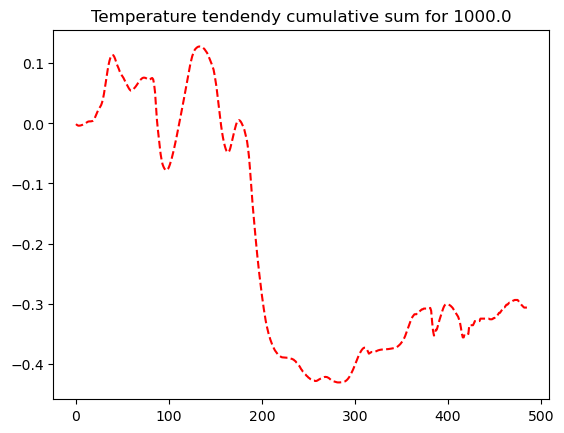

In [75]:
# The heat transport is not correct because the grid metrics is not being used to properly calculate the magnitude
heat_cumsum_fabio = np.sum(np.cumsum(transp_across_contour, axis=1),axis=0)

plt.plot(heat_cumsum_fabio, '--r')
plt.title(f'Temperature tendendy cumulative sum for {contour_depth}');

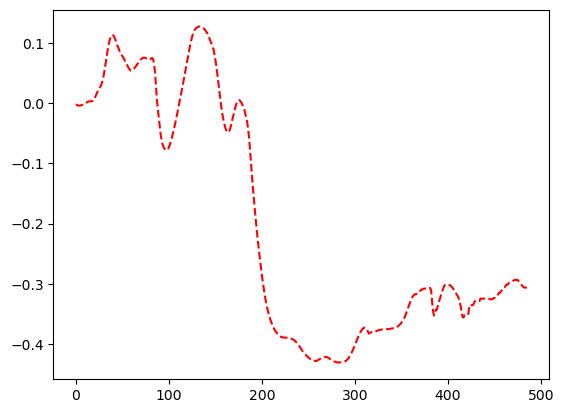

In [76]:
#FS: Summing across depth and cumulative sum per latitude
mine = transp_across_contour.sum(axis=0).cumsum()

plt.plot(mine, 'r--');

### <span style="color: cyan"> Testing for one row and try to close the budget </span>

In [178]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature as NEF

def make_map():
    projection=ccrs.PlateCarree()
    ncols=4
    fig, AX = plt.subplots(ncols=ncols, figsize=(12, 8),
                        subplot_kw=dict(projection=projection))

	# setting the ROI: area of Australia East Coast
    extent = [148, 156, -39, -24]
    xticks = [149, 151, 153, 155]
    yticks = [-39, -37, -35, -33, -31, -29, -27, -25, -23]

    for NN in range(ncols):
        gl1  = AX[NN].gridlines(draw_labels = True  ,
                            color       = 'gray',
                            linestyle   = '--'  ,
                            alpha       = 0.5   ,
                            xlocs       = xticks,
                            ylocs       = yticks)
        gl1.top_labels = False
        gl1.right_labels = False
        gl1.xformatter  = LONGITUDE_FORMATTER
        gl1.yformatter  = LATITUDE_FORMATTER


        AX[NN].set_extent(extent)
        coast = NEF(category='physical', scale='10m', facecolor='lightgray', name='coastline')
        AX[NN].add_feature(coast, edgecolor='black')


    return fig, AX

In [177]:
ds_metric.shflux

<xarray.DataArray 'shflux' (ocean_time: 30, eta_rho: 317, xi_rho: 272)>
dask.array<open_dataset-shflux, shape=(30, 317, 272), dtype=float32, chunksize=(1, 317, 272), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-02-01 1994-02-02 ... 1994-03-02
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 265 266 267 268 269 270 271
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 310 311 312 313 314 315 316
Attributes:
    long_name:       time-averaged surface net heat flux
    units:           watt meter-2
    negative_value:  upward flux, cooling
    positive_value:  downward flux, heating
    time:            ocean_time
    grid:            grid
    location:        face
    field:           surface heat flux, scalar, series

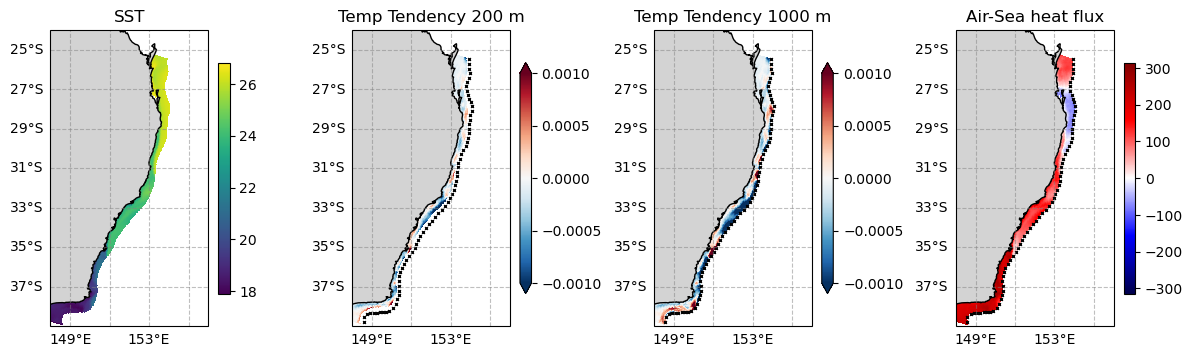

In [186]:
fig, ax = make_map()


plot0 = ds_metric.temp.where(h<1000).isel(s_rho=-1, ocean_time=0).plot(ax=ax[0], x='lon_rho', y='lat_rho',
                                                                       cbar_kwargs={'shrink': 0.3}); ax[0].set_title('SST')

plot1 = my_int_temp_rate.where(h<200).plot(ax=ax[1], x='lon_rho', y='lat_rho',
                                           cbar_kwargs={'shrink': 0.3},
                                           vmin=-0.001, vmax=0.001,
                                           cmap='RdBu_r'); ax[1].set_title('Temp Tendency 200 m');
ax[1].plot(lon_along_contour[::5], lat_along_contour[::5], 'xk', markersize=2)

plot2 = my_int_temp_rate.where(h<1000).plot(ax=ax[2], x='lon_rho', y='lat_rho',
                                            cbar_kwargs={'shrink': 0.3},
                                            vmin=-0.001, vmax=0.001,
                                            cmap='RdBu_r'); ax[2].set_title('Temp Tendency 1000 m');
ax[2].plot(lon_along_contour[::5], lat_along_contour[::5], 'xk', markersize=2)

plot3 = ds_metric.shflux.where(h<1000).isel(ocean_time=0).plot(ax=ax[3], x='lon_rho', y='lat_rho',
                                            cbar_kwargs={'shrink': 0.3},
                                            cmap='seismic'); ax[3].set_title('Air-Sea heat flux');
ax[3].plot(lon_along_contour[::5], lat_along_contour[::5], 'xk', markersize=2)

plot0.colorbar.set_label('')
plot1.colorbar.set_label('')
plot2.colorbar.set_label('')
plot3.colorbar.set_label('')


fig.tight_layout()


#### <span style="color:magenta">Making the distances and coordinates something more realistic</span>

In [77]:
# lon_along_contour = contour_ordering.one
# lat_along_contour = contour_ordering.two

# contour_index_array = np.arange(1, len(contour_ordering)+1)

# # don't need the multi-index anymore, replace with contour count and save
# lat_along_contour.coords['contour_index'] = contour_index_array
# lon_along_contour.coords['contour_index'] = contour_index_array



In [78]:
# ''' STILL NEEDS ADAPTATION TO MY ROMS!!'''

# # if there is a bend in the contour, add the distance using the half-length of the diagonal
# # instead of the sum of 2 edges, to be more representative.
# distance_along_contour = np.zeros((num_points))

# x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
# y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])

# skip = False
# # note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# # which for this latitude range there is not. If using a different latitude range, choose an x value that is
# # not a nan/land for the entire latitude range
# dx = ds_metric.dx
# dy = ds_metric.dy

# for count in range(1, num_points):
#     print(count)
#     if skip == True:
#         skip = False
#         continue
#     # For Y_INDICES
#     if count in y_indices:
#         if count + 1 in y_indices:
#             # note dxu and dyt do not vary in x:
#             jj = np.where(mask_y_transport_numbered==count)[0]
#             distance_along_contour[count-1] = dx[jj, count].values
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)
#             jj1 = np.where(mask_y_transport_numbered==count+1)
#             half_diagonal_distance = 0.5 * np.sqrt(dy[jj0].values**2 + dx[jj1].values**2)
#             distance_along_contour[count-1] = half_diagonal_distance
#             distance_along_contour[count] = half_diagonal_distance
#             # skip to next count:
#             skip = True

#     # FOR X_INDICES
#     else:
#         if count + 1 in x_indices:
#             jj = np.where(mask_x_transport_numbered==count)[0]
#             distance_along_contour[count-1] = dy[jj, count].values
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)
#             jj1 = np.where(mask_y_transport_numbered==count+1)
#             half_diagonal_distance = 0.5 * np.sqrt(dy[jj0].values**2 + dx[jj1].values**2)
#             distance_along_contour[count-1] = half_diagonal_distance
#             distance_along_contour[count] = half_diagonal_distance
#             # skip to next count:
#             skip = True

# # # fix last value:
# # if distance_along_contour[-1] == 0:
# #     count = count + 1
# #     if count in y_indices:
# #         jj = np.where(mask_y_transport_numbered==count)[0]
# #         distance_along_contour[-1] = (dxu[jj])[0]
# #     else:
# #         jj = np.where(mask_x_transport_numbered==count)[0]
# #         distance_along_contour[-1] = (dyt[jj])[0]

# # # units are 10^3 km:
# # distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3

In [79]:
# jj0 = np.where(mask_x_transport_numbered==count)
# jj1 = np.where(mask_y_transport_numbered==count+1)

In [80]:
# mask_y_transport_numbered[np.where(mask_y_transport_numbered>0)]

### This is my method of interpolation. Comparing the two final figures of heat cumsum they look very similar. However, the final arrays have a difference of one element between my method and his.  

In [81]:
# # FS: my method to interpolate the mask into different grid
# mask_x_transportDA = xr.DataArray(mask_x_transport, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
#                                              'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
#                                              'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
# mask_y_transportDA = xr.DataArray(mask_y_transport, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
#                                              'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
#                                              'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
# mask_x_transportDA_numbered = xr.DataArray(mask_x_transport_numbered, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
#                                              'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
#                                              'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
# mask_y_transportDA_numbered = xr.DataArray(mask_y_transport_numbered, coords={'eta_rho': ds.eta_rho.data, 'xi_rho': ds.xi_rho.data,
#                                              'lat_rho': (('eta_rho', 'xi_rho'), lat_rho.data),
#                                              'lon_rho': (('eta_rho', 'xi_rho'), lon_rho.data)}, dims=['eta_rho', 'xi_rho'])
# mask_x_transportDA, mask_y_transportDA

In [82]:
# ds['mask_x_transport'] = mask_x_transportDA
# ds['mask_y_transport'] = mask_y_transportDA
# ds['mask_x_transport_numbered'] = mask_x_transportDA_numbered
# ds['mask_y_transport_numbered'] = mask_y_transportDA_numbered
# ds

In [83]:
# ds['mask_x_transport_Ugrd'] = ds.mask_x_transport.interp(eta_rho=ds.eta_u, xi_rho=ds.xi_u, method='nearest')
# ds['mask_y_transport_Vgrd'] = ds.mask_y_transport.interp(eta_rho=ds.eta_v, xi_rho=ds.xi_v, method='nearest')
# ds['mask_x_transport_Ugrd_numbered'] = ds.mask_x_transport_numbered.interp(eta_rho=ds.eta_u, xi_rho=ds.xi_u, method='nearest')
# ds['mask_y_transport_Vgrd_numbered'] = ds.mask_y_transport_numbered.interp(eta_rho=ds.eta_v, xi_rho=ds.xi_v, method='nearest')
# ds.mask_x_transport_Ugrd, ds.mask_x_transport, ds.mask_y_transport_Vgrd, ds.mask_y_transport


In [84]:
# fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
# ds.mask_x_transport_Ugrd.plot(ax=ax[0, 0])
# ds.mask_x_transport_Ugrd_numbered.plot(ax=ax[1, 0])
# ds.mask_y_transport_Vgrd.plot(ax=ax[0, 1])
# ds.mask_y_transport_Vgrd_numbered.plot(ax=ax[1, 1])

In [85]:
# coordinates=dict(one=lon_rho, two=lat_rho)
# coordinatesU=dict(one=lon_u, two=lat_u)
# coordinatesV=dict(one=lon_v, two=lat_v)

# mask_x_transport_Ugrd = xr.DataArray(ds.mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_Vgrd = xr.DataArray(ds.mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
# mask_x_transport_Ugrd_numbered = xr.DataArray(ds.mask_x_transport_Ugrd_numbered, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_Vgrd_numbered = xr.DataArray(ds.mask_y_transport_Vgrd_numbered, coords = coordinatesV, dims = ['eta_v', 'xi_v'])


# # rename dimensions as simply eta/xi
# mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
# mask_x_transport_numbered_Ugrd = mask_x_transport_Ugrd_numbered.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_numbered_Vgrd = mask_y_transport_Vgrd_numbered.rename({'eta_v': 'eta','xi_v': 'xi'})

In [86]:
# # FS: doing this we will get the (x, y) for the contour points as tuples
# mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
# mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True) # will remove all the zeros

# mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
# mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)  # will remove all the zeros

# contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
# contour_ordering = contour_ordering.sortby(contour_ordering)
# contour_index_array = np.arange(1, len(contour_ordering)+1)

In [87]:
# temp = ds.temp.isel(ocean_time=0)
# v = ds.v_northward.isel(ocean_time=0)
# u = ds.u_eastward.isel(ocean_time=0)

In [88]:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1


# # Bad calculation of heat transport, due to the use of rho points for temp when I have u/v in their origianl location!!!! FS
# v_heat_trans = (temp * v * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})
# u_heat_trans = (temp * u * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice).rename({'eta_rho': 'eta','xi_rho': 'xi'})


# # temporary while rho and u/v grid are not properly set
# u_heat_trans = u_heat_trans.isel(xi=slice(0, -1))
# v_heat_trans = v_heat_trans.isel(eta=slice(0, -1))

In [89]:
# fig, ax = plt.subplots(ncols=2)
# u_heat_trans.isel(s_rho=-1).plot(ax=ax[0]); ax[0].set_title('U Heat flux');
# v_heat_trans.isel(s_rho=-1).plot(ax=ax[1]); ax[1].set_title('V Heat flux');

In [90]:
# transp_across_contour = extract_transp_across_contour(temp, u_heat_trans, v_heat_trans)

In [91]:
# # The heat transport is not correct because the grid metrics is not being used to properly calculate the magnitude
# heat_cumsum = np.sum(np.cumsum(transp_across_contour, axis=1),axis=0)

# plt.plot(heat_cumsum, '--r')
# plt.title(f'"Heat transport" cumulative sum for {contour_depth}')

### Doing the calculation using the diagnostic output

In [92]:

# def extract_transp_across_contour(temp, var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

#     zlen = len(temp[:,0,0])
#     tlen = 1
#     # print(tlen,zlen)
#     transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

#     for tt in range(0,tlen): # loop through time
#         for zz in range(0,zlen): # loop through z-levels

#             print('Debugging high memory usage: ')
#             print('Time: %s, and Sigma level: %s' % (tt, zz))

#             # U and V points
#             var_x_tmp = var_x.isel(s_rho=zz) * mask_x_transport
#             var_y_tmp = var_y.isel(s_rho=zz) * mask_y_transport
            
#             print('var_x_tmp/var_y_tmp shapes after mask multip.: %s, %s' % (var_x_tmp.shape, var_y_tmp.shape))
            
#             # fig, ax = plt.subplots(ncols=2)
#             # p0 = ax[0].pcolor(var_x_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p0)
#             # p1 = ax[1].pcolor(var_y_tmp, vmin=-1.5e7, vmax=1.5e7); plt.colorbar(p1)

#             # stack transports into 1d and drop any points not on contour:
#             x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
#             x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
#             y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
#             y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

#             print('x_var_1d_tmp/y_var_1d_tmp shapes after stack: %s, %s' % (x_var_1d_tmp.shape, y_var_1d_tmp.shape))

#             # ORIGINAL combine all points on contour:
#             transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
#             transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
#             transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
#             transp_across_contour_tmp.coords['contour_index'] = contour_index_array
#             transp_across_contour_tmp = transp_across_contour_tmp.load()

#             # Instead of concatenating, I'll assume for now that the total flux is flux_x + flux_y
#             transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
#             transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
#             transp_across_contour_tmp.coords['contour_index'] = contour_index_array
#             transp_across_contour_tmp = transp_across_contour_tmp.load()
            
#             # print(tt, zz, transp_across_contour_tmp.shape)
#             transp_across_contour[tt,zz,:] = transp_across_contour_tmp
#             del transp_across_contour_tmp

#     return transp_across_contour.squeeze()  # getting rid of unit dimention

In [93]:
# # Reading the diagnostic file
# dg = xr.open_dataset('/mnt/c/Users/z5392640/OneDrive - UNSW/Documents/PhD/scientific_topics/heat_budget/neil_nci/colette/outer_dia.nc')


In [94]:
# dg

In [95]:
# x_temp = dg.temp_xadv.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi') + dg.temp_xdiff.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi')
# y_temp = dg.temp_yadv.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi') + dg.temp_ydiff.isel(ocean_time=0).rename(eta_rho='eta', xi_rho='xi')

# transp_across_contour = extract_transp_across_contour(temp, x_temp, y_temp)

In [96]:
# '''NOT SURE ABOUT THE MAGNITUDE HERE.....'''



# heat_cumsum = np.sum(np.cumsum(transp_across_contour, axis=1),axis=0)

# plt.plot(heat_cumsum, '--r')
# plt.title(f'"Heat transport" cumulative sum for {contour_depth}')

In [97]:
# y_temp.isel(s_rho=-1).plot()